<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/population_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import external packages

In [193]:
!pip install -q rioxarray
!pip install -q h3
!pip install -q pydeck

In [194]:
import geemap
import ee
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import json

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Download the Data

- area of interest
- World Population Estimate dataset from google earth engine

In [197]:
!wget https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg -O gurgaon.gpkg

--2024-05-06 13:19:50--  https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg [following]
--2024-05-06 13:19:50--  https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304 (96K) [application/octet-stream]
Saving to: ‘gurgaon.gpkg’

gurgaon.gpkg        100%[===================>]  96.00K  --.-KB/s    in 0.02s   

2024-05-06 13:19:50 (6.01 MB/s) - ‘g

In [198]:
gurgaon_gdf = gpd.read_file('gurgaon.gpkg', crs='EPSG:4326')
geojson = gurgaon_gdf.to_json()

## Convert the geopackage file to ee.Geometry
featureCollection = ee.FeatureCollection(json.loads(geojson))
geometry = featureCollection.geometry()

## world population data

[how world population is estimated](https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/)

In [199]:
world_pop_image = ee.ImageCollection("WorldPop/GP/100m/pop")\
.filter(ee.Filter.eq('country','IND'))\
.filter(ee.Filter.eq('year', 2020))\
.first().clip(geometry)

In [200]:
center = (gurgaon_gdf.centroid[0].y, gurgaon_gdf.centroid[0].x)
Map = geemap.Map(center=center, zoom=10)
boundary_viz_params = {
    'color':'red',
    "width":2,
    "lineType":"solid",
    'fillColorOpacity': 0.1
}
Map.addLayer(ee_object=geometry, vis_params=boundary_viz_params, name='Gurgaon Boundary')
viz_params = {
    'min': 0,
    'max': 50,
    'bands': ['population']
}
Map.addLayer(world_pop_image, viz_params, name='Population')
Map

Map(center=[28.437398083125167, 77.06463665845695], controls=(WidgetControl(options=['position', 'transparent_…

In [201]:
geemap.ee_export_image(
    world_pop_image,
    filename='population.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/population.tif


## Converting the raster to xyz point data


In [243]:
def raster_to_xyz(raster_file, val_col):
    xds = rioxarray.open_rasterio('population.tif')\
            .sel(band=1)\
            .to_pandas()

    xds = xds.stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: val_col})
    return xds

def convert_to_gdf(df, aoi):
    df['geometry'] = list(map(Point, zip(df['lng'], df['lat'])))
    gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')

    ## Clip the geometry
    gdf = gdf[gdf['geometry'].within(aoi)]
    print(f"Total of {gdf.shape[0]} points are in the dataset")

    return gdf


def aggregate_gdf_by_h3(gdf, APERTURE_SIZE, agg='sum', val_col='population'):
    hex_col = 'hex'+str(APERTURE_SIZE)

    # find hex indices for all the points
    gdf[hex_col] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

    # calculate temperature average per hex
    hex_data = gdf.groupby(hex_col)[val_col].agg(agg).to_frame(val_col).reset_index()

    return hex_data

1. Convert raster to xyz points

In [237]:
xds = raster_to_xyz('population.tif', val_col='population', )
xds = xds[xds['population']>0]
print(xds.shape)
print(xds['population'].min(), xds['population'].max())
xds.head()

(19364, 3)
5.0605803 112.68387


,lat,lng,population
0,28.510111,77.003728,18.283073
1,28.510111,77.004627,29.219259
2,28.510111,77.005525,32.136192
3,28.510111,77.006423,33.248539
4,28.510111,77.007322,32.943436


2. Convert the points to GeoDataFrame

In [242]:
aoi = gurgaon_gdf['geometry'].iloc[0]
gdf = convert_to_gdf(xds, aoi)
gdf.sample(5)

Total of 12923 points are in the dataset


,lat,lng,population,geometry
17704,28.387940,77.025288,23.966928,POINT (77.02529 28.38794)
15697,28.402314,77.090865,33.197083,POINT (77.09086 28.40231)
8759,28.449924,77.047746,78.175842,POINT (77.04775 28.44992)
17689,28.387940,77.011813,21.070642,POINT (77.01181 28.38794)
13226,28.419382,77.089967,52.605709,POINT (77.08997 28.41938)


3. Aggregate all the values by h3 indices

In [263]:
APERTURE_SIZE=8
pop_hex_data = aggregate_gdf_by_h3(gdf, APERTURE_SIZE=APERTURE_SIZE, agg='sum', val_col='population')
pop_hex_data.sample(3)

,hex8,population
165,883da11ad9fffff,4513.674805
23,883da111e5fffff,4833.822266
65,883da1185bfffff,4011.033203


After creating the hexagons using the h3 spatial index, the point data are reduced to 3545 from 299484.This saves a significant amount of disk space.

Also compared to geometries which are mostly having coordinates with float numbers, it is more efficient to store a h3 index as it is a string object with fixed number of characters (15-16 characters)

To view the h3 spatial indices, check out this [Uber h3 viewer](https://wolf-h3-viewer.glitch.me/)

## Visualizing the results in pydeck

for visualizing the surface temperature data, we will first format the data


- Normalizing the temperature values
- then color coding the temperature values using a colormap
- splitting the colormap values to make it compatible with pydeck `get_fill_color` attribute
- Formatting a tooltip for interactive data visualization

In [264]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].astype(int)

    return xdf

def create_h3_hex_layer(df,hex_col):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

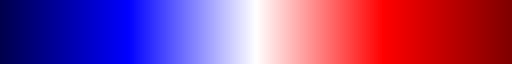

In [265]:
## Choose a colormap
cmap = colormaps['seismic']
cmap

Generating the tooltip:

In [266]:
tooltip = {
        "html": "<b>Population</b>: {population}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

## Finally plotting the results on a 3D map

In [267]:
xdf

,hex10,population,R,G,B,A
0,8a3da1034007fff,63,0,0,219,100
1,8a3da103400ffff,33,0,0,140,100
2,8a3da1034017fff,62,0,0,216,100
3,8a3da103401ffff,64,0,0,222,100
4,8a3da1034027fff,80,8,8,255,100
...,...,...,...,...,...,...
7326,8a3da11aed97fff,93,57,57,255,100
7327,8a3da11aed9ffff,70,0,0,236,100
7328,8a3da11aeda7fff,96,69,69,255,100
7329,8a3da11aedaffff,85,29,29,255,100


In [268]:
## Apply the colormap to the dataframe
value_col='population'

xdf = colormap_dataframe(df=pop_hex_data, value_col=value_col, cmap=cmap)

## Now create a H3HexagonLayer
hex_col = f'hex{APERTURE_SIZE}'
layer = create_h3_hex_layer(xdf, hex_col)

# Set the viewport location
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 255,
          "G": 45,
          "R": 45,
          "hex8": "883da10341fffff",
          "population": 2284
        },
        {
          "A": 100,
          "B": 177,
          "G": 177,
          "R": 255,
          "hex8": "883da10345fffff",
          "population": 4454
        },
        {
          "A": 100,
          "B": 61,
          "G": 61,
          "R": 255,
          "hex8": "883da10349fffff",
          "population": 5307
        },
        {
          "A": 100,
          "B": 171,
          "G": 0,
          "R": 0,
          "hex8": "883da1034bfffff",
          "population": 1056
        },
        {
          "A": 100,
          "B": 221,
          "G": 221,
          "R": 255,
          "hex8": "883da1034dfffff",
          "population": 4121
        },
        {
          "A": 100,
          "B": 112,
          "G": 0,
          "R": 0,
          "hex8": "883da10361fffff",
          "population": 419
        },
        {
          "A": 100,
          "B": 255,
          "G": 61,
          "R": 61,
          "hex8": "883da10365fffff",
          "population": 2410
        },
        {
          "A": 100,
          "B": 213,
          "G": 213,
          "R": 255,
          "hex8": "883da10369fffff",
          "population": 4167
        },
        {
          "A": 100,
          "B": 84,
          "G": 0,
          "R": 0,
          "hex8": "883da1036bfffff",
          "population": 113
        },
        {
          "A": 100,
          "B": 157,
          "G": 157,
          "R": 255,
          "hex8": "883da1036dfffff",
          "population": 4598
        },
        {
          "A": 100,
          "B": 118,
          "G": 0,
          "R": 0,
          "hex8": "883da11137fffff",
          "population": 495
        },
        {
          "A": 100,
          "B": 236,
          "G": 0,
          "R": 0,
          "hex8": "883da11185fffff",
          "population": 1743
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 231,
          "hex8": "883da111a1fffff",
          "population": 6112
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 205,
          "hex8": "883da111a3fffff",
          "population": 6501
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 193,
          "hex8": "883da111a5fffff",
          "population": 6706
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 223,
          "hex8": "883da111a7fffff",
          "population": 6258
        },
        {
          "A": 100,
          "B": 5,
          "G": 5,
          "R": 255,
          "hex8": "883da111a9fffff",
          "population": 5725
        },
        {
          "A": 100,
          "B": 153,
          "G": 153,
          "R": 255,
          "hex8": "883da111abfffff",
          "population": 4637
        },
        {
          "A": 100,
          "B": 0,
          "G": 0,
          "R": 167,
          "hex8": "883da111adfffff",
          "population": 7077
        },
        {
          "A": 100,
          "B": 255,
          "G": 193,
          "R": 193,
          "hex8": "883da111b5fffff",
          "population": 3407
        },
        {
          "A": 100,
          "B": 244,
          "G": 0,
          "R": 0,
          "hex8": "883da111bdfffff",
          "population": 1841
        },
        {
          "A": 100,
          "B": 255,
          "G": 145,
          "R": 145,
          "hex8": "883da111e1fffff",
          "population": 3034
        },
        {
          "A": 100,
          "B": 255,
          "G": 104,
          "R": 104,
          "hex8": "883da111e3fffff",
          "population": 2724
     

## WorldPop Global Project Population Data: Estimated Age and Sex Structures of Residential Population per 100x100m Grid Square

In [269]:
world_pop_image = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex")\
.filter(ee.Filter.eq('country','IND'))\
.filter(ee.Filter.eq('year', 2020))\
.first().clip(geometry)

In [270]:
world_pop_image

## Reference

1. [Create a choropleth map using h3 and plotly](https://medium.com/@ransaka/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-c65555744c87)

2. [Uber h3 py notebook](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)

3. [All available matplotlib colormaps for plotting](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

4. [WorldPop Global Project Population Data: Estimated Residential Population per 100x100m Grid Square](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description)